In [15]:
import pandas as pd
import numpy as np
import spacy
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm
import matplotlib.pyplot as plt
from importnb import Notebook
from captum.attr import IntegratedGradients, Lime
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from matplotlib import cm, colors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import streamlit as st

# xAI

In [17]:
# all of this is for transformer

device = torch.device("cpu")  # Captum doesn't support MPS
print("Using device:", device)

# Load tokenized climate data
CLIMATE_TOKENISED_TRANSFORMER_DIR = './cache/climate_tokenised_bert.pkl'
CLIMATE_TOKENISED_RNN_DIR = './cache/climate_tokenised_rnn.pkl'

with open(CLIMATE_TOKENISED_TRANSFORMER_DIR, 'rb') as f:
    climate_tokenised_transformer = pickle.load(f)

subset_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
climate_tokenised_transformer_subset = {
    "input_ids": climate_tokenised_transformer["input_ids"][subset_indices],
    "token_type_ids": climate_tokenised_transformer["token_type_ids"][subset_indices],
    "attention_mask": climate_tokenised_transformer["attention_mask"][subset_indices]
}

# Load model and tokenizer
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()
print("Model and tokenizer loaded successfully from:", model_path)

# Prepare data tensors and embeddings
input_ids = torch.clone(climate_tokenised_transformer_subset["input_ids"]).detach().to(dtype=torch.long, device=device)
attention_mask = torch.clone(climate_tokenised_transformer_subset["attention_mask"]).detach().to(dtype=torch.float32, device=device)
# Extract embeddings directly from input_ids
embedding_layer = bert_uncased_finetuned.get_input_embeddings()
embeddings = embedding_layer(input_ids).clone().detach().requires_grad_(True).to(device)
# Derive tokens from input_ids for reconstruction
tokens_list = [bert_tokenizer.convert_ids_to_tokens(ids.cpu().numpy()) for ids in input_ids]


# === Helper Functions === #

# Reconstruct sentence and attributions
def reconstruct_sentence(tokens, attributions, tokenizer):
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token, score in zip(tokens, attributions):
        if token.startswith("##"):
            current_score += score
        else:
            if current_word:  # Save previous word
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            current_word, current_score = token, score

    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    special_tokens = tokenizer.special_tokens_map.values()
    filtered_tokens = [t for t in word_tokens if t not in special_tokens]
    filtered_attributions = [
        a for t, a in zip(word_tokens, word_attributions) if t not in special_tokens
    ]
    sentence = " ".join(filtered_tokens)
    return sentence, filtered_attributions

# Visualize token attributions
def visualize_token_attributions(tokens, attributions, cmap='bwr', title=None):
    attributions = np.array(attributions)
    assert len(tokens) == len(attributions), "Tokens and attributions lengths do not match!"
    norm = colors.Normalize(vmin=attributions.min(), vmax=attributions.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    html_content = f"<div style='line-height:1.6;'>"
    for token, score in zip(tokens, attributions):
        color = colors.rgb2hex(scalar_map.to_rgba(score))
        html_content += f"<span style='background-color:{color}; padding:2px; margin:2px;'>{token}</span> "
    html_content += "</div>"
    display(HTML(html_content))

# Compute Integrated Gradients
def compute_integrated_gradients(embeddings, attention_mask, sample_input_ids, tokenizer, target_class=1, steps=50):
    def forward_func(embeddings, attention_mask=None):
        outputs = bert_uncased_finetuned(inputs_embeds=embeddings, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=target_class,
        n_steps=steps,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_ig.sum(dim=-1)[0].detach().cpu().numpy()
    return reconstruct_sentence(tokens, token_attributions, tokenizer)

def compute_integrated_gradients_per_sample(embeddings, attention_mask, sample_input_ids, tokenizer, model):
    def forward_func(embeddings, attention_mask=None):
        outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    ig = IntegratedGradients(forward_func)
    baseline = torch.zeros_like(embeddings)
    attributions_ig = ig.attribute(
        inputs=embeddings,
        baselines=baseline,
        additional_forward_args=(attention_mask,),
        target=0,  # Adjust target as needed
        n_steps=50,
    )

    # Flatten the input IDs: shape [1, seq_len] -> [seq_len]
    flat_input_ids = sample_input_ids.squeeze(0)  # shape: (seq_len,)
    flat_input_ids = flat_input_ids.cpu().numpy().tolist()
    tokens = tokenizer.convert_ids_to_tokens(flat_input_ids)


    # Flatten attributions: shape [1, seq_len, hidden_dim] -> [seq_len, hidden_dim], then sum across hidden_dim
    token_attributions = attributions_ig.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    return tokens, token_attributions

def compute_lime(sample_input_ids, attention_mask, tokenizer, target_class=0, n_samples=100):
    def forward_func(input_ids, attention_mask=None):
        outputs = bert_uncased_finetuned(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    lime = Lime(forward_func)
    attributions_lime = lime.attribute(
        inputs=sample_input_ids,
        n_samples=n_samples,
        additional_forward_args=(attention_mask,),
        target=target_class,
    )
    
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].cpu().numpy())
    token_attributions = attributions_lime[0].detach().cpu().numpy().flatten()
    
    return reconstruct_sentence(tokens, token_attributions, tokenizer)

# === Main Execution Loop === #
for idx in range(len(climate_tokenised_transformer_subset["input_ids"])):
    print(f"\n--- Sample {idx + 1} ---")
    
    # Prepare single-sample embeddings, attention mask, and input_ids
    sample_embeddings = embeddings[idx].unsqueeze(0)
    sample_attention_mask = attention_mask[idx].unsqueeze(0)
    sample_input_ids = input_ids[idx].unsqueeze(0)
    
    # IG
    sentence_ig, word_attributions_ig = compute_integrated_gradients(
        embeddings=sample_embeddings,
        attention_mask=sample_attention_mask,
        sample_input_ids=sample_input_ids,
        tokenizer=bert_tokenizer,
        target_class=0,
        steps=50
    )
    print(f"Reconstructed Sentence: {sentence_ig}")
    visualize_token_attributions(sentence_ig.split(), word_attributions_ig, cmap='bwr', title="IG Attributions")
    print(f"Word-Level Attributions (IG): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_ig.split(), word_attributions_ig)])}")

    # LIME
    sentence_lime, word_attributions_lime = compute_lime(
        sample_input_ids=sample_input_ids,
        attention_mask=sample_attention_mask,
        tokenizer=bert_tokenizer,
        target_class=0,
        n_samples=100
    )
    visualize_token_attributions(sentence_lime.split(), word_attributions_lime, cmap='coolwarm', title="LIME Attributions")
    print(f"Word-Level Attributions (LIME): {', '.join([f'{word} ({score:.4f})' for word, score in zip(sentence_lime.split(), word_attributions_lime)])}")


Using device: cpu
Model and tokenizer loaded successfully from: ./models/transformer_results

--- Sample 1 ---
Reconstructed Sentence: climate change doesn ’ t cause volcanic eruptions .


Word-Level Attributions (IG): climate (0.0436), change (0.0366), doesn (0.2440), ’ (0.7762), t (0.0998), cause (0.0325), volcanic (-0.2297), eruptions (0.0668), . (0.0090)


Word-Level Attributions (LIME): climate (0.0000), change (0.0000), doesn (0.0000), ’ (0.1353), t (-0.0522), cause (-0.0011), volcanic (0.3483), eruptions (0.1959), . (0.0042)

--- Sample 2 ---
Reconstructed Sentence: va tennis ball boy collapses in the tennis court due to climate change .


Word-Level Attributions (IG): va (0.4608), tennis (-0.0049), ball (-0.0887), boy (0.0024), collapses (0.0158), in (-0.1062), the (-0.0823), tennis (-0.0011), court (0.0183), due (-0.1389), to (-0.0086), climate (-0.0041), change (-0.0365), . (-0.0098)


Word-Level Attributions (LIME): va (-0.0365), tennis (0.1371), ball (0.0000), boy (-0.1999), collapses (-0.2990), in (0.0595), the (0.0000), tennis (0.0000), court (-0.0556), due (0.1097), to (0.0000), climate (0.2091), change (0.0000), . (0.0351)

--- Sample 3 ---
Reconstructed Sentence: north america has experienced an average winter , with temperatures and snowfall totals in line with historical trends . do not be fooled . this phenomenon is known as " as climate change " .


Word-Level Attributions (IG): north (0.0379), america (0.0015), has (-0.0373), experienced (0.0223), an (0.0023), average (0.0232), winter (0.0305), , (0.0132), with (-0.0020), temperatures (0.0402), and (0.0004), snowfall (0.0484), totals (0.0039), in (0.0193), line (0.0112), with (-0.0042), historical (-0.0007), trends (-0.0045), . (0.0158), do (-0.0086), not (-0.0102), be (-0.0161), fooled (-0.0062), . (0.0148), this (-0.0018), phenomenon (-0.0005), is (-0.0086), known (0.0012), as (-0.0039), " (0.0140), as (-0.0251), climate (0.0164), change (-0.0016), " (0.0152), . (0.0120)


Word-Level Attributions (LIME): north (0.0000), america (0.0000), has (-0.0061), experienced (0.0000), an (0.0000), average (0.0000), winter (0.0293), , (0.0000), with (0.0000), temperatures (0.0335), and (0.0000), snowfall (0.0653), totals (0.0000), in (0.0000), line (0.0000), with (0.0000), historical (-0.0046), trends (0.0000), . (0.0000), do (0.0000), not (0.0000), be (0.0000), fooled (-0.0083), . (0.0000), this (0.0000), phenomenon (0.0000), is (0.0000), known (0.0000), as (0.0000), " (0.0000), as (-0.0085), climate (0.0087), change (0.0000), " (0.0000), . (0.0000)

--- Sample 4 ---
Reconstructed Sentence: they ' re gonna do the same with climate change when it starts to get really bad . quote t


Word-Level Attributions (IG): they (-0.0540), ' (0.2819), re (-0.1079), gonna (-0.0925), do (-0.0554), the (-0.0292), same (-0.1198), with (-0.0679), climate (0.1039), change (-0.0738), when (0.0330), it (-0.0289), starts (-0.0574), to (-0.0427), get (-0.0656), really (-0.0997), bad (-0.0548), . (0.1207), quote (-0.2311), t (-0.1143)


Word-Level Attributions (LIME): they (0.0000), ' (0.0000), re (0.0000), gonna (0.0000), do (0.0186), the (0.0000), same (0.0000), with (0.0000), climate (0.0217), change (0.0000), when (0.0000), it (0.0000), starts (0.0000), to (0.0000), get (0.0000), really (0.0000), bad (0.0000), . (0.0216), quote (-0.0436), t (-0.0155)

--- Sample 5 ---
Reconstructed Sentence: hello america , who would have ever thought the world could be taken ; by fearing climate change , the common cold , and the flu ?


Word-Level Attributions (IG): hello (0.0733), america (-0.0121), , (0.0224), who (-0.4695), would (-0.0900), have (-0.1018), ever (-0.0650), thought (0.0385), the (-0.0281), world (-0.0389), could (0.0151), be (-0.1097), taken (-0.0071), ; (-0.0218), by (-0.0740), fearing (-0.0987), climate (0.1248), change (-0.0585), , (0.0446), the (-0.1350), common (-0.0285), cold (0.0616), , (0.0530), and (0.0256), the (0.0104), flu (0.0626), ? (0.0761)


Word-Level Attributions (LIME): hello (-0.2281), america (0.0000), , (0.0375), who (-0.1757), would (0.0822), have (0.0000), ever (0.0000), thought (0.0514), the (0.0000), world (0.0000), could (0.0517), be (-0.0431), taken (0.0000), ; (0.0000), by (0.0000), fearing (-0.1203), climate (0.2642), change (0.0000), , (0.0000), the (0.0000), common (0.0000), cold (0.0301), , (0.0000), and (0.0000), the (0.0000), flu (0.0097), ? (0.0000)

--- Sample 6 ---
Reconstructed Sentence: fucking hell this weather makes me really fucking anxious bc climate change is only getting worse and worse and my god we ’ ll all be dead within a couple of years


Word-Level Attributions (IG): fucking (0.1795), hell (-0.0685), this (-0.0875), weather (0.5136), makes (-0.1720), me (-0.0990), really (-0.1043), fucking (0.0365), anxious (0.0053), bc (-0.0119), climate (0.0648), change (-0.0468), is (-0.0502), only (-0.0449), getting (-0.0368), worse (-0.0048), and (-0.0086), worse (0.0020), and (-0.0063), my (-0.0033), god (-0.0759), we (-0.0227), ’ (0.3569), ll (-0.0067), all (-0.0149), be (-0.0230), dead (-0.0070), within (0.0079), a (0.0198), couple (-0.0005), of (0.0145), years (0.0239)


Word-Level Attributions (LIME): fucking (0.0000), hell (0.0000), this (0.0000), weather (0.2840), makes (-0.0552), me (0.0000), really (0.0000), fucking (0.0000), anxious (0.0000), bc (0.0000), climate (0.0000), change (0.0000), is (0.0000), only (0.0000), getting (0.0000), worse (0.0000), and (0.0000), worse (0.0000), and (0.0000), my (0.0000), god (0.0000), we (0.0000), ’ (0.4606), ll (0.0000), all (0.0000), be (0.0000), dead (0.0000), within (0.0000), a (0.0000), couple (0.0000), of (0.0000), years (0.0000)

--- Sample 7 ---
Reconstructed Sentence: great to finally have this important unesco / sc publication finished out techniques and approaches to tack harmful al bloom research in the context of climate change . thanks to all the authors for excellent chapters .


Word-Level Attributions (IG): great (0.2961), to (-0.1581), finally (-0.0776), have (-0.2571), this (-0.1465), important (-0.0168), unesco (0.0525), / (-0.0086), sc (-0.0268), publication (0.0126), finished (0.0274), out (-0.0610), techniques (-0.0141), and (-0.0272), approaches (-0.0328), to (-0.0441), tack (-0.0746), harmful (-0.0666), al (0.0247), bloom (0.0092), research (0.0204), in (0.0320), the (-0.0188), context (-0.0335), of (-0.0109), climate (0.1250), change (-0.0010), . (0.0486), thanks (0.0098), to (-0.0838), all (-0.0274), the (-0.0679), authors (-0.0394), for (-0.0609), excellent (-0.0246), chapters (-0.0677), . (0.0480)


Word-Level Attributions (LIME): great (0.0047), to (0.0000), finally (0.0000), have (-0.0262), this (0.0000), important (0.0000), unesco (0.0735), / (-0.0182), sc (0.0069), publication (0.0000), finished (0.2357), out (0.0000), techniques (0.0000), and (0.0000), approaches (-0.0076), to (0.0000), tack (-0.0077), harmful (-0.0620), al (0.0000), bloom (0.0000), research (0.0000), in (0.0000), the (0.0000), context (-0.0156), of (0.0000), climate (0.0883), change (0.0000), . (0.0000), thanks (-0.0479), to (0.0000), all (0.0000), the (0.0000), authors (0.0000), for (0.0000), excellent (0.0000), chapters (-0.0495), . (0.0000)

--- Sample 8 ---
Reconstructed Sentence: climate change is one of the world ' s most pressing problems . # red so , it makes no sense when mainstream media publishes an article about # climate with a pay . this is profit over people and planet . # ms should be free front - page news everyday .


Word-Level Attributions (IG): climate (0.2440), change (-0.0213), is (-0.1858), one (-0.2039), of (-0.0523), the (-0.0499), world (0.0134), ' (0.0656), s (-0.0545), most (-0.0538), pressing (0.0104), problems (-0.0124), . (0.0384), # (-0.0125), red (-0.1301), so (-0.0223), , (0.0193), it (-0.0340), makes (-0.0644), no (-0.0085), sense (-0.0137), when (0.0302), mainstream (-0.0186), media (-0.0230), publishes (-0.0373), an (-0.0331), article (-0.0292), about (-0.0524), # (-0.0302), climate (0.1831), with (-0.0251), a (0.0365), pay (-0.0345), . (0.0580), this (-0.0151), is (-0.0456), profit (0.0063), over (-0.0282), people (-0.0090), and (-0.0045), planet (0.0005), . (0.0349), # (-0.0124), ms (-0.0585), should (-0.0203), be (-0.0418), free (0.0037), front (-0.0081), - (0.0634), page (-0.0501), news (-0.0167), everyday (-0.0223), . (0.0181)


Word-Level Attributions (LIME): climate (0.1030), change (0.0000), is (-0.0779), one (0.0000), of (0.0000), the (0.0000), world (0.0299), ' (0.0000), s (0.0000), most (0.0000), pressing (0.0000), problems (0.0000), . (0.0000), # (0.0000), red (-0.0696), so (0.0000), , (0.0409), it (0.0000), makes (-0.0602), no (0.0000), sense (0.0000), when (0.0000), mainstream (0.0000), media (0.0000), publishes (0.0000), an (0.0000), article (0.0000), about (0.0000), # (0.0000), climate (0.0855), with (0.0000), a (0.0000), pay (0.0000), . (0.0337), this (0.0000), is (0.0000), profit (0.0000), over (0.0000), people (0.0000), and (0.0000), planet (0.0000), . (0.0000), # (0.0000), ms (-0.0113), should (0.0000), be (0.0000), free (0.0000), front (0.0000), - (0.0000), page (0.0000), news (0.0000), everyday (-0.0246), . (0.0000)

--- Sample 9 ---
Reconstructed Sentence: can people start questioning the " johnson got the big calls right " crap ? worst co cases in western europe , afghanistan , climate chang

Word-Level Attributions (IG): can (0.4249), people (0.0292), start (-0.0958), questioning (-0.1528), the (-0.4600), " (0.2216), johnson (-0.0830), got (-0.0756), the (-0.1203), big (-0.1018), calls (-0.0073), right (-0.0591), " (0.2387), crap (-0.0664), ? (-0.0556), worst (-0.0465), co (-0.0377), cases (-0.0244), in (-0.2326), western (-0.0892), europe (-0.0347), , (0.0157), afghanistan (0.0009), , (0.0742), climate (0.0246), change (0.0337), , (0.0392), corrupt (0.0165), contracts (0.0452), to (-0.0849), cr (0.0572), , (0.0549), br (0.0123), , (0.0357), back (0.0926), . (0.0158), # (-0.0538), news (-0.1133)


Word-Level Attributions (LIME): can (-0.0371), people (0.0000), start (0.0000), questioning (0.0000), the (0.0000), " (0.1041), johnson (0.0000), got (0.0000), the (-0.0034), big (0.0000), calls (-0.0289), right (0.0000), " (0.1090), crap (-0.0449), ? (0.0502), worst (0.0000), co (-0.0272), cases (0.0000), in (0.0000), western (0.0000), europe (0.0983), , (0.0000), afghanistan (0.0000), , (0.0000), climate (0.0709), change (0.0000), , (0.0057), corrupt (-0.1716), contracts (0.0000), to (0.0000), cr (0.0000), , (0.0855), br (0.0090), , (0.0000), back (0.0184), . (0.0554), # (0.0000), news (0.0000)

--- Sample 10 ---
Reconstructed Sentence: i ’ m raising two kids and , ya know , i guess i just can ’ t be polite , court , and respectful to people like joe man who are threatening their near - and - long - term futures with his failures to protect u . s . democracy and address climate change .


Word-Level Attributions (IG): i (0.0551), ’ (0.1369), m (0.0071), raising (-0.0232), two (-0.0068), kids (-0.0263), and (-0.0146), , (0.0147), ya (-0.0104), know (-0.0295), , (0.0109), i (-0.0096), guess (-0.0059), i (-0.0073), just (-0.0207), can (-0.0120), ’ (0.0464), t (-0.0323), be (-0.0235), polite (-0.0058), , (0.0098), court (0.0179), , (0.0211), and (0.0040), respectful (-0.0028), to (0.0047), people (-0.0018), like (-0.0104), joe (-0.0078), man (0.0046), who (-0.0090), are (-0.0334), threatening (-0.0035), their (-0.0020), near (0.0151), - (0.0225), and (0.0014), - (0.0148), long (0.0146), - (0.0170), term (-0.0080), futures (0.0069), with (-0.0066), his (-0.0011), failures (0.0018), to (-0.0013), protect (-0.0108), u (0.0123), . (0.0198), s (-0.0075), . (0.0324), democracy (-0.0069), and (0.0010), address (-0.0453), climate (0.0378), change (-0.0054), . (0.0296)


Word-Level Attributions (LIME): i (0.0000), ’ (0.4201), m (0.0000), raising (0.0000), two (0.0000), kids (-0.0371), and (0.0223), , (0.0000), ya (0.0000), know (0.0000), , (0.0000), i (-0.0044), guess (0.0000), i (0.0000), just (0.0000), can (0.0000), ’ (0.1778), t (0.0000), be (-0.0157), polite (0.0000), , (-0.0085), court (0.0000), , (0.0409), and (0.0000), respectful (0.0000), to (0.0000), people (0.0000), like (0.0000), joe (0.0000), man (0.0000), who (0.0000), are (0.0000), threatening (0.0000), their (0.0000), near (0.0165), - (-0.0117), and (0.0000), - (0.0000), long (0.0000), - (0.0000), term (0.0000), futures (0.0758), with (0.0000), his (0.0000), failures (0.0000), to (0.0000), protect (0.0000), u (0.0000), . (0.0000), s (-0.0273), . (0.0000), democracy (0.0000), and (0.0000), address (0.0000), climate (0.0008), change (0.0000), . (0.0000)


In [18]:
from collections import defaultdict

# I DON'T THINK THIS MAKE SENSE TO HAVE, AS TRANSFOMER HAS DYNAMIC EMBEDDINGS !!!

def get_global_top_words(
    climate_tokenised_transformer_subset, 
    bert_tokenizer, 
    model, 
    embeddings, 
    attention_mask, 
    top_n=10
):
    """
    Extract the global top influential words for the model based on IG coefficients across all samples.
    """

    word_scores = defaultdict(float)

    def compute_integrated_gradients_per_sample(model, embeddings, attention_mask, sample_input_ids, tokenizer):
        def forward_func(embeddings, attention_mask=None):
            outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
            return torch.softmax(outputs.logits, dim=-1)

        ig = IntegratedGradients(forward_func)
        baseline = torch.zeros_like(embeddings)
        
        # Compute attributions for this sample
        attributions_ig = ig.attribute(
            inputs=embeddings, 
            baselines=baseline, 
            additional_forward_args=(attention_mask,),
            target=0,        # or another target class if needed
            n_steps=50
        )

        # 1) Flatten the input IDs to shape [seq_len]
        input_ids_flat = sample_input_ids.squeeze(0).cpu().numpy().tolist()
        # 2) Convert them to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids_flat)

        # 3) Sum attributions across the embedding dimension, 
        #    then flatten shape to [seq_len]
        token_attributions = attributions_ig.sum(dim=-1).squeeze(0).detach().cpu().numpy()

        return tokens, token_attributions

    for idx in range(len(climate_tokenised_transformer_subset["input_ids"])):
        # Prepare per-sample data
        sample_embeddings = embeddings[idx].unsqueeze(0)       # shape: [1, seq_len, hidden_dim]
        sample_attention_mask = attention_mask[idx].unsqueeze(0) # shape: [1, seq_len]
        sample_input_ids = climate_tokenised_transformer_subset["input_ids"][idx].unsqueeze(0) # shape: [1, seq_len]

        tokens, token_attributions = compute_integrated_gradients_per_sample(
            model=model,
            embeddings=sample_embeddings,
            attention_mask=sample_attention_mask,
            sample_input_ids=sample_input_ids,
            tokenizer=bert_tokenizer
        )

        # Reconstruct words from tokens + attributions (merging subwords)
        sentence, word_attributions = reconstruct_sentence(tokens, token_attributions, bert_tokenizer)

        # Aggregate IG scores for each word across samples
        for word, score in zip(sentence.split(), word_attributions):
            word_scores[word] += score

    # Sort words by absolute attribution value, return top N
    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    return sorted_words[:top_n]

global_top_words = get_global_top_words(
    climate_tokenised_transformer_subset=climate_tokenised_transformer_subset,
    bert_tokenizer=bert_tokenizer,
    model=bert_uncased_finetuned,
    embeddings=embeddings,
    attention_mask=attention_mask,
    top_n=30
)

print("Global Top Words by IG:")
for word, score in global_top_words:
    print(f"{word}: {score:.4f}")

Global Top Words by IG:
’: 1.3164
the: -0.9811
climate: 0.9639
weather: 0.5136
.: 0.5061
": 0.4895
who: -0.4785
va: 0.4608
,: 0.4287
to: -0.4188
can: 0.4129
have: -0.3589
': 0.3475
great: 0.2961
is: -0.2902
in: -0.2875
this: -0.2509
doesn: 0.2440
makes: -0.2363
quote: -0.2311
volcanic: -0.2297
fucking: 0.2160
be: -0.2140
really: -0.2040
one: -0.2039
change: -0.1746
questioning: -0.1528
due: -0.1389
red: -0.1301
news: -0.1300


In [19]:

# top global words / features of the GRU

def reconstruct_sentence(tokens, attributions, idx2word):
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token_idx, score in zip(tokens, attributions):
        token_str = idx2word.get(token_idx, "<unk>")  # get string from index
        if token_str.startswith("##"):
            # subword piece
            current_word += token_str[2:]
            current_score += score
        else:
            # finish the previous word
            if current_word:
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            # start a new word
            current_word, current_score = token_str, score

    # Catch the last word
    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    return word_tokens, word_attributions

def get_global_top_words_gru(
    tokenized_sequences,
    rnn_model,
    vocab,  # This is your word2idx
    embedding_tensor,
    device,
    top_n=10,
    target_class=0
):
    rnn_model.eval()
    word_scores = defaultdict(float)

    # Create the reverse dictionary: idx2word
    idx2word = {v: k for k, v in vocab.items()}

    def forward_func(embeds):
        output, hidden = rnn_model.gru(embeds)
        forward_top = hidden[-2, :, :]
        backward_top = hidden[-1, :, :]
        concat_top = torch.cat([forward_top, backward_top], dim=1)
        logits = rnn_model.classification_layer(concat_top)
        return torch.sigmoid(logits)

    # Suppose we have a custom_ig or we do an integrated gradients approach here
    # For each token_list
    for token_list in tokenized_sequences:
        token_indices = [vocab.get(tok, vocab["<unk>"]) for tok in token_list]
        input_ids = torch.tensor(token_indices, dtype=torch.long).to(device)

        embeds = embedding_tensor[input_ids].unsqueeze(0).float()
        baseline = torch.zeros_like(embeds).float()

        # Example custom IG or captum call returning ig_attr
        # ...
        ig_attr = custom_ig(forward_func, baseline, embeds, n_steps=50)

        # Sum across embedding_dim => shape: (seq_len,)
        token_attributions = ig_attr.sum(dim=-1).squeeze(0).detach().cpu().numpy()

        # Use idx2word inside reconstruct_sentence
        word_tokens, word_attr = reconstruct_sentence(token_indices, token_attributions, idx2word)
        for w, a in zip(word_tokens, word_attr):
            word_scores[w] += a

    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    return sorted_words[:top_n]



# USAGE

CLIMATE_TOKENISED_RNN_DIR = './cache/climate_tokenised_rnn.pkl'
with open(CLIMATE_TOKENISED_RNN_DIR, 'rb') as f:
    tokenized_sequences_rnn = pickle.load(f)  

VOCAB_FILE_PATH = "./cache/vocab_idx.pkl"
with open('./cache/vocab_idx.pkl', 'rb') as f:
    vocab_idx = pickle.load(f)

TOP_MODEL_PATH = "./models/bidirectional_gru_model.pth"
gru_model = torch.load(TOP_MODEL_PATH)

embedding_tensor = gru_model.embedding_layer.weight.data


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_tensor = gru_model.embedding_layer.weight.data.to(device)  
gru_model.to(device)

# Get global top words
global_top_words_gru = get_global_top_words_gru(
    tokenized_sequences=tokenized_sequences_rnn,
    rnn_model=gru_model,
    vocab=vocab_idx,
    embedding_tensor=embedding_tensor,
    device=device,
    top_n=30,
    target_class=0
)
# Print results
print("Global Top Words by IG (GRU):")
for word, score in global_top_words_gru:
    print(f"{word}: {score:.4f}")


/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/621499880.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_model = torch.load(TOP_MODEL_PATH)


NameError: name 'custom_ig' is not defined

In [20]:
# GET TOP WORDS FOR GRU

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

def reconstruct_sentence(tokens, attributions, vocab):
    """
    If your 'tokens' are already whole words (e.g., from a custom tokenizer),
    you can simplify this function. If you do have subword pieces, adjust to merge them.
    """
    # Example: tokens are just words from vocab indices
    # But if you have subword tokens (e.g. "climat", "##e"),
    # you'll need to merge them accordingly.
    
    word_tokens, word_attributions = [], []
    current_word, current_score = "", 0.0

    for token_idx, score in zip(tokens, attributions):
        token_str = vocab[token_idx] if token_idx in vocab else "<unk>"
        # If you have subword logic, check if token_str starts with '##'
        if token_str.startswith("##"):  
            # subword piece
            current_word += token_str[2:]  
            current_score += score
        else:
            # finish the previous word
            if current_word:
                word_tokens.append(current_word)
                word_attributions.append(current_score)
            # start a new word
            current_word, current_score = token_str, score

    # Catch the last word
    if current_word:
        word_tokens.append(current_word)
        word_attributions.append(current_score)

    return word_tokens, word_attributions

def get_global_top_words_gru(
    tokenized_sequences,
    rnn_model,
    vocab,
    embedding_tensor,
    device,
    top_n=10,
    target_class=0
):
    """
    Compute global top words by Integrated Gradients (IG) across all tokenized sequences for a GRU model.
    """
    rnn_model.eval()
    word_scores = defaultdict(float)

    def forward_func(embeds):
        output, hidden = rnn_model.gru(embeds)
        forward_top = hidden[-2, :, :]
        backward_top = hidden[-1, :, :]
        concat_top = torch.cat([forward_top, backward_top], dim=1)
        logits = rnn_model.classification_layer(concat_top)
        return torch.sigmoid(logits)

    ig = IntegratedGradients(forward_func)

    for token_list in tokenized_sequences:
        token_indices = [vocab.get(tok, vocab["<unk>"]) for tok in token_list]
        input_ids = torch.tensor(token_indices, dtype=torch.long).to(device)

        embeds = embedding_tensor[input_ids].unsqueeze(0).to(device).float()  # Force float32
        baseline = torch.zeros_like(embeds).to(device).float()  # Force float32

        # Convert step_sizes to float32 in Captum
        attributions_ig = ig.attribute(
            inputs=embeds,
            baselines=baseline,
            target=target_class,
            n_steps=50,
            method="gausslegendre",
        )

        token_attributions = attributions_ig.sum(dim=-1).squeeze(0).detach().cpu().numpy()
        word_tokens, word_attr = reconstruct_sentence(token_list, token_attributions, vocab)
        for w, a in zip(word_tokens, word_attr):
            word_scores[w] += a

    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    return sorted_words[:top_n]



# USAGE

CLIMATE_TOKENISED_RNN_DIR = './cache/climate_tokenised_rnn.pkl'
with open(CLIMATE_TOKENISED_RNN_DIR, 'rb') as f:
    tokenized_sequences_rnn = pickle.load(f)  

VOCAB_FILE_PATH = "./cache/vocab_idx.pkl"
with open('./cache/vocab_idx.pkl', 'rb') as f:
    vocab_idx = pickle.load(f)

TOP_MODEL_PATH = "./models/bidirectional_gru_model.pth"
gru_model = torch.load(TOP_MODEL_PATH)

embedding_tensor = gru_model.embedding_layer.weight.data


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_tensor = gru_model.embedding_layer.weight.data.to(device)  
gru_model.to(device)

# Get global top words
global_top_words_gru = get_global_top_words_gru(
    tokenized_sequences=tokenized_sequences_rnn,
    rnn_model=gru_model,
    vocab=vocab_idx,
    embedding_tensor=embedding_tensor,
    device=device,
    top_n=30,
    target_class=0
)
# Print results
print("Global Top Words by IG (GRU):")
for word, score in global_top_words_gru:
    print(f"{word}: {score:.4f}")

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/3960997996.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_model = torch.load(TOP_MODEL_PATH)


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

Blue represents negative attributions (meaning the token has a negative impact on the target class).
Red represents positive attributions (meaning the token has a positive impact on the target class).

target class = 1

1 = misinfo.

So blue = more factual, red = more misinfo 


# Topic modelling

Tweets are short by nature, which could pose challenges for LDA, as it relies on the assumption that each document (tweet) has enough content to model a topic distribution.

Preprocessing for LDA: You may need to aggregate tweets to form meaningful "documents."
LSA: Works more naturally with short texts but may not offer distinct "topic distributions."

If you want clear topic distributions, LDA is better.
If you are looking for semantic relationships and dimensionality reduction (e.g., clustering or visualisation), LSA is suitable.

## LSA

In [7]:
import pickle
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import streamlit as st
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import fasttext
from sklearn.decomposition import PCA

In [8]:
PREDICTIONS_PATH = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions.csv"
predictions_df = pd.read_csv(PREDICTIONS_PATH)

In [ ]:
misinfo_cases = predictions_df[predictions_df['predicted_label_gru'] == 'misinformation']

# Extract the text column for LSA analysis
misinfo_texts = misinfo_cases['text'].dropna()

# Step 1: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(misinfo_texts)

# Step 2: Perform Truncated SVD (LSA)
n_components = 5  # Number of latent topics
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

# Extract top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()
top_words_per_topic = {}
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
    top_words_per_topic[f"Topic {i+1}"] = [term for term, _ in sorted_terms]

topics_df = pd.DataFrame(top_words_per_topic)

# Display topics with their top words
st.title("LSA Topics with Top Words")
st.dataframe(topics_df)


2024-12-30 19:05:45.780 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-30 19:05:45.820 
  command:

    streamlit run /Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-30 19:05:45.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-30 19:05:45.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-30 19:05:45.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

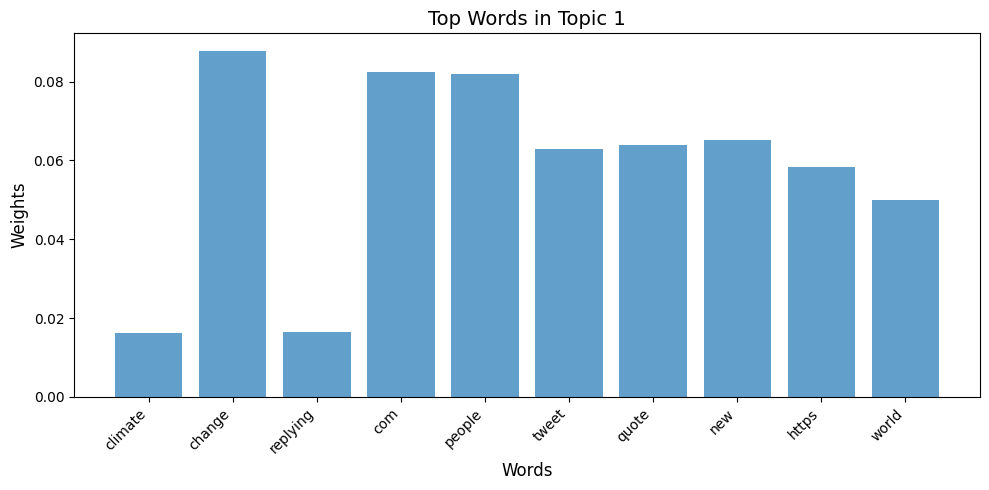

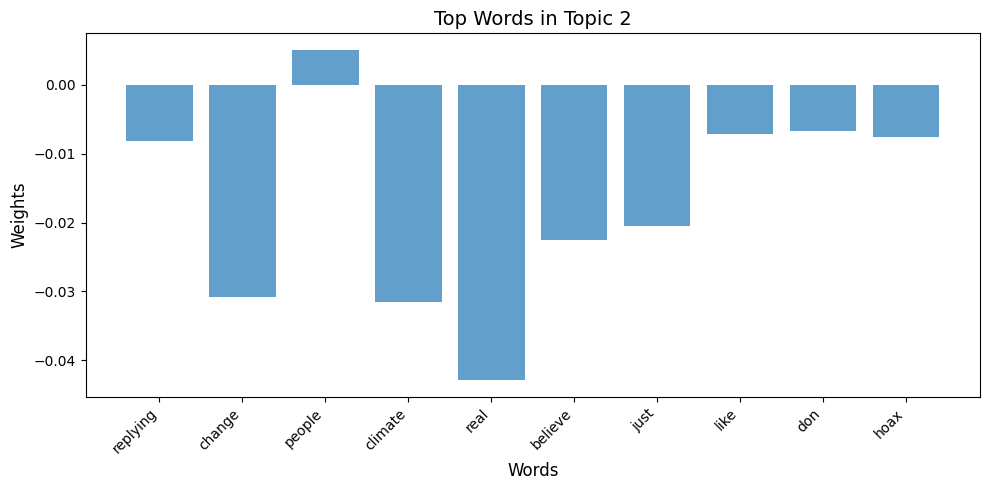

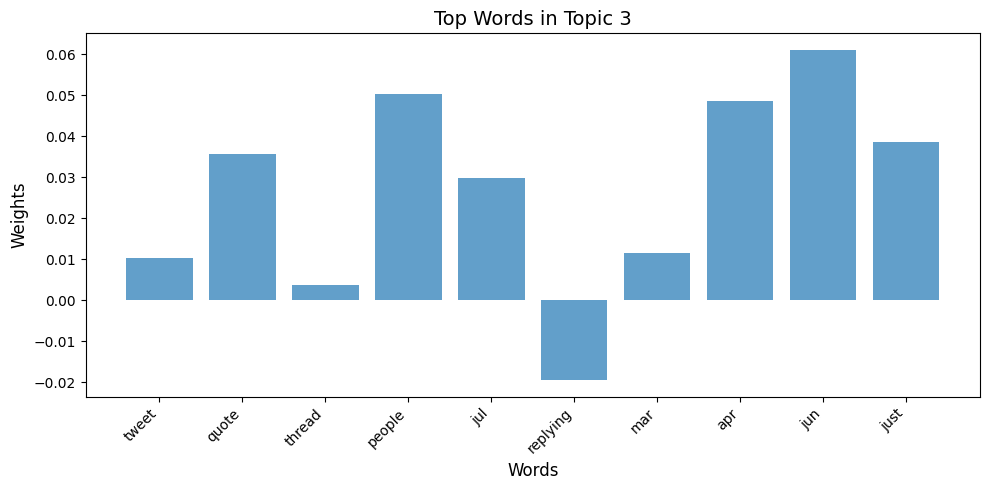

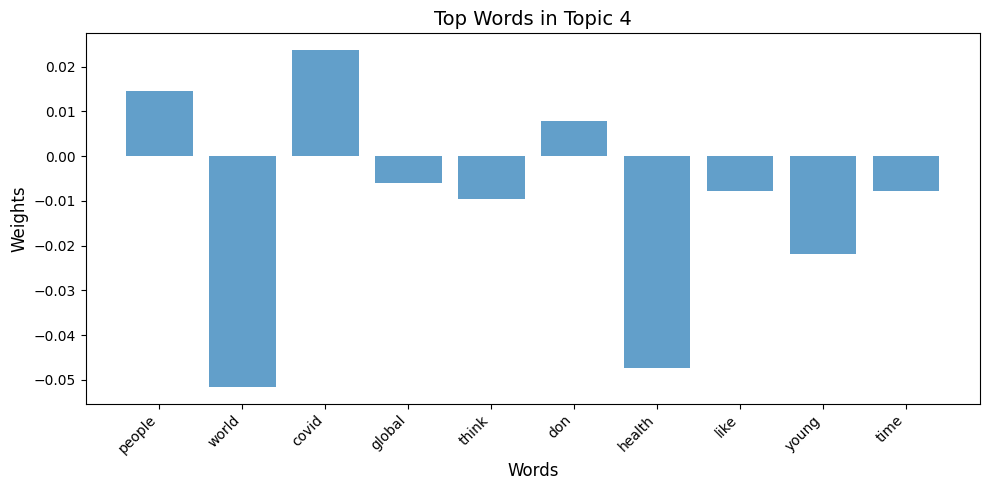

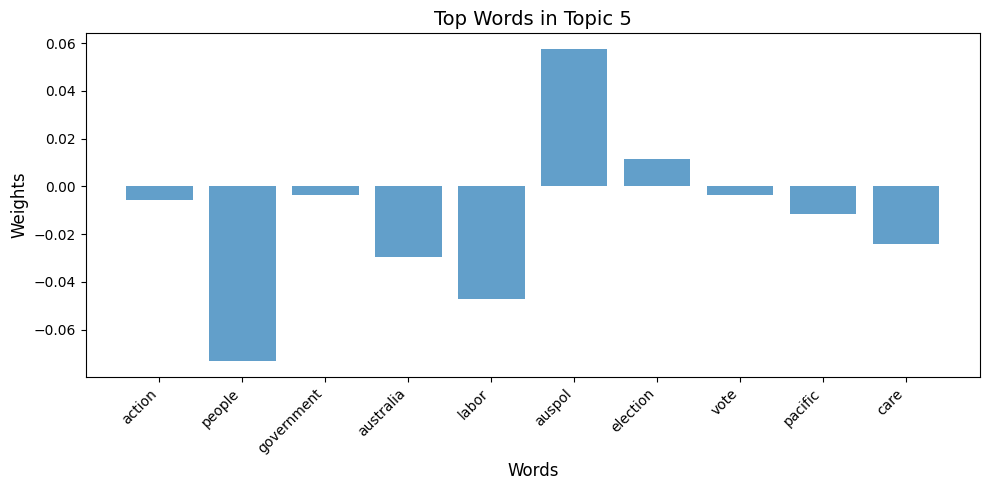

In [ ]:
# Visualize the LSA topics using a bar chart for each topic
for i, topic in enumerate(topics_df.columns):
    plt.figure(figsize=(10, 5))
    words = topics_df[topic].values
    weights = lsa_model.components_[i][:len(words)]  # Corresponding weights for top words

    # Plot bar chart for the current topic
    plt.bar(words, weights[:len(words)], alpha=0.7)
    plt.title(f"Top Words in {topic}", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Weights", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/3144180184.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")
/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/3144180184.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


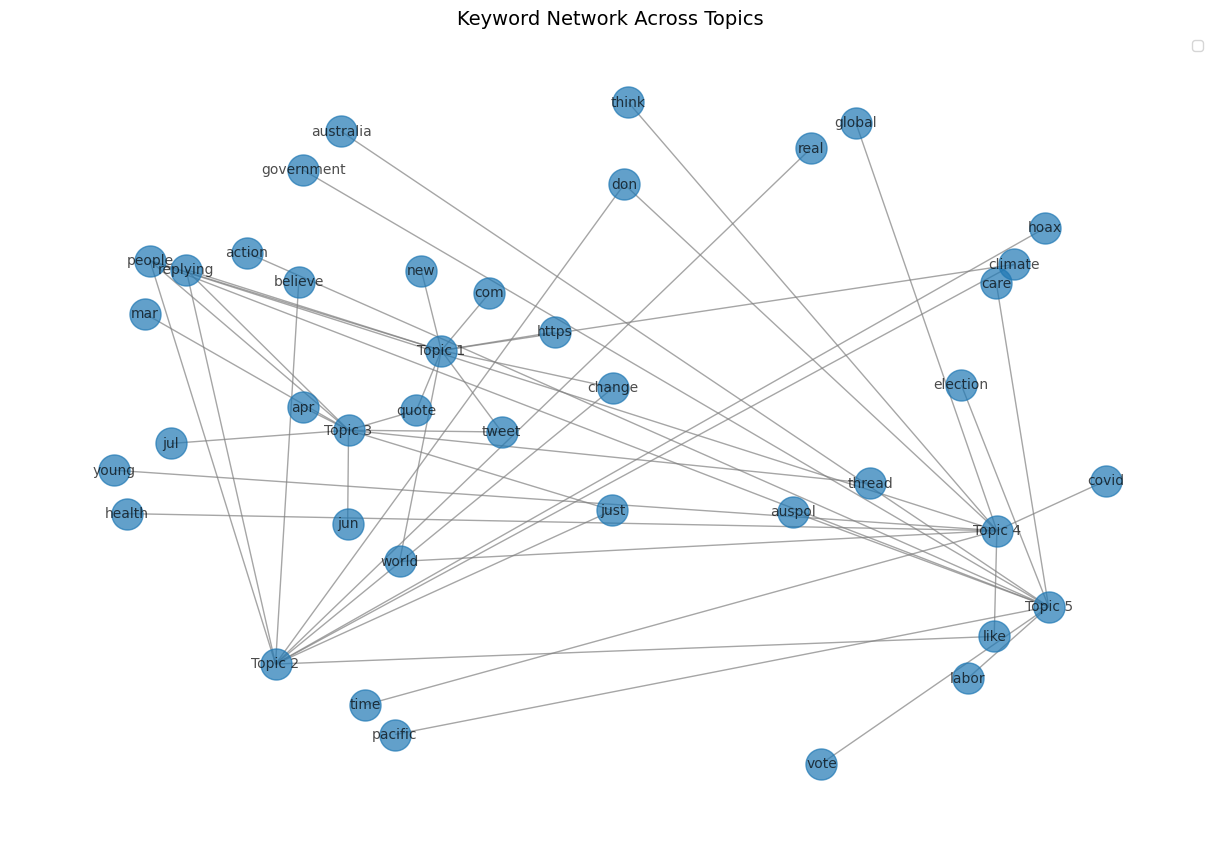

/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/3144180184.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_cases['sentiment'] = misinfo_cases['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


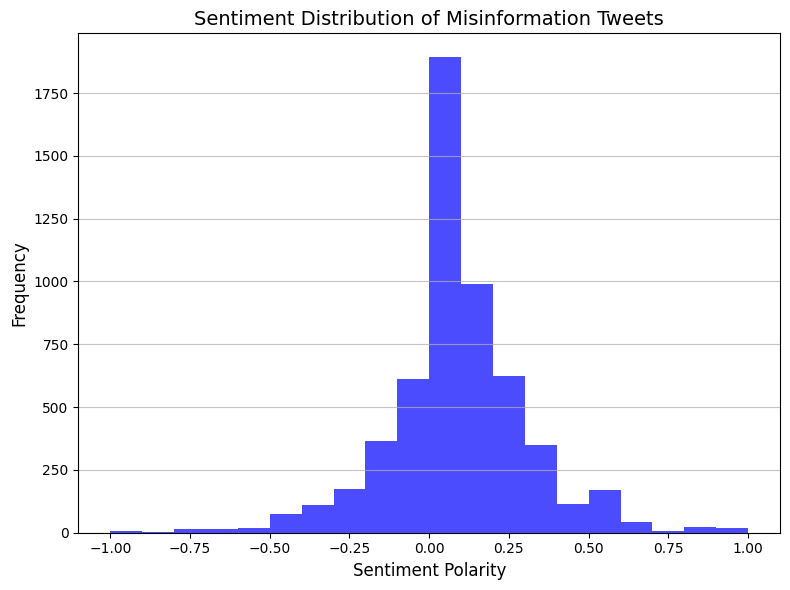

In [11]:
# **3. Keyword Network Visualization**
# Create a graph of keywords and their weights for each topic
G = nx.Graph()
for i, topic in enumerate(topics_df.columns):
    for word, weight in zip(topics_df[topic], lsa_model.components_[i][:len(topics_df[topic])]):
        G.add_edge(topic, word, weight=weight)

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network Across Topics", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# **4. Sentiment Analysis**
from textblob import TextBlob

# Calculate sentiment polarity for each misinformation tweet
misinfo_cases['sentiment'] = misinfo_cases['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(misinfo_cases['sentiment'], bins=20, color='blue', alpha=0.7)
plt.title("Sentiment Distribution of Misinformation Tweets", fontsize=14)
plt.xlabel("Sentiment Polarity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()



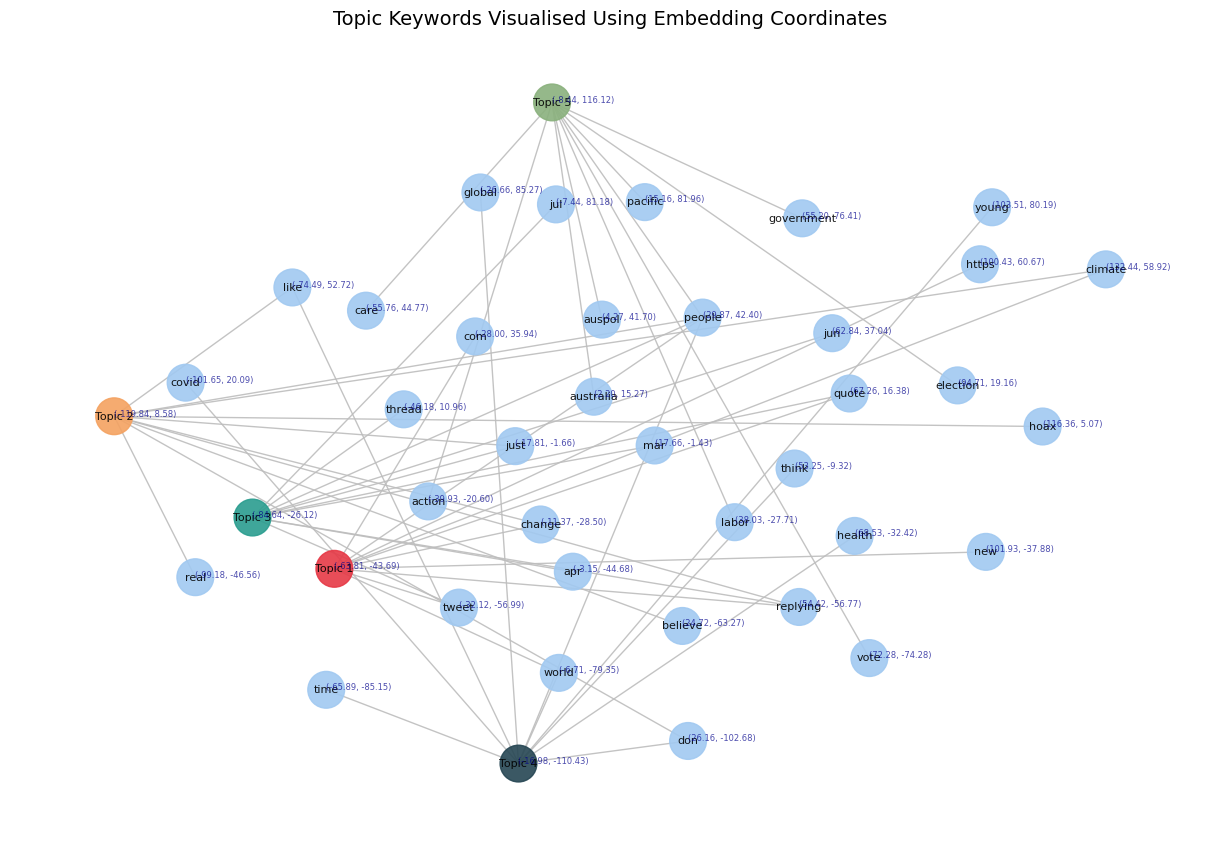

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE

# --------------------------------------------------
# 1. Build Your Graph (Topics & Words as Nodes)
# --------------------------------------------------
G = nx.Graph()

# Assume topics_df is a DataFrame where each column represents a topic, 
# and each cell in the column is a top word for that topic.
# Also assume we have lsa_model.components_ that gives the "weight" 
# or importance of each word in that topic.

# Predefined colour palette for better visuals
predefined_colours = [
    "#E63946", "#F4A261", "#2A9D8F", "#264653", "#8AB17D", "#E76F51", "#4A4E69"
]
topic_colours = {
    topic: predefined_colours[i % len(predefined_colours)] for i, topic in enumerate(topics_df.columns)
}

# Add edges and nodes to the graph
for i, topic in enumerate(topics_df.columns):
    for word, weight in zip(topics_df[topic], lsa_model.components_[i][:len(topics_df[topic])]):
        G.add_edge(topic, word, weight=weight)

# --------------------------------------------------
# 2. Prepare Node Embeddings
# --------------------------------------------------
# Create embeddings for nodes
node_embeddings = {
    node: np.random.rand(100) for node in G.nodes()
}

# --------------------------------------------------
# 3. Reduce Node Embeddings to 2D (e.g., t-SNE)
# --------------------------------------------------
all_nodes = list(G.nodes())
emb_matrix = np.array([node_embeddings[node] for node in all_nodes])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=15, learning_rate=200)
emb_2d = tsne.fit_transform(emb_matrix)

# Build a dict: {node: (x, y)} for networkx
pos_2d = {node: (emb_2d[i, 0], emb_2d[i, 1]) for i, node in enumerate(all_nodes)}

# --------------------------------------------------
# 4. Assign Colours
# --------------------------------------------------
# Topic nodes get unique colours; word nodes get a uniform colour
word_colour = "#A1C9F1"  # light blue for words
node_colors = [
    topic_colours[node] if node in topics_df.columns else word_colour
    for node in G.nodes()
]

# Assign uniform edge colour
edge_colour = "#BDBDBD"  # neutral grey

# --------------------------------------------------
# 5. Draw the Graph Using the t-SNE Coordinates
# --------------------------------------------------
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos=pos_2d,          # t-SNE-based positions
    with_labels=True,
    node_size=700,
    font_size=8,
    edge_color=edge_colour,
    node_color=node_colors,
    alpha=0.9
)

# Add explicit x and y labels for context
for node, (x, y) in pos_2d.items():
    plt.text(x, y, f"({x:.2f}, {y:.2f})", fontsize=6, color="darkblue", alpha=0.7)

plt.title("Topic Keywords Visualised Using Embedding Coordinates", fontsize=14)
plt.show()


/var/folders/9b/zwzkyxhs7h7759872hzp3mz80000gn/T/ipykernel_3124/2555390323.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_cases['cluster'] = clusters


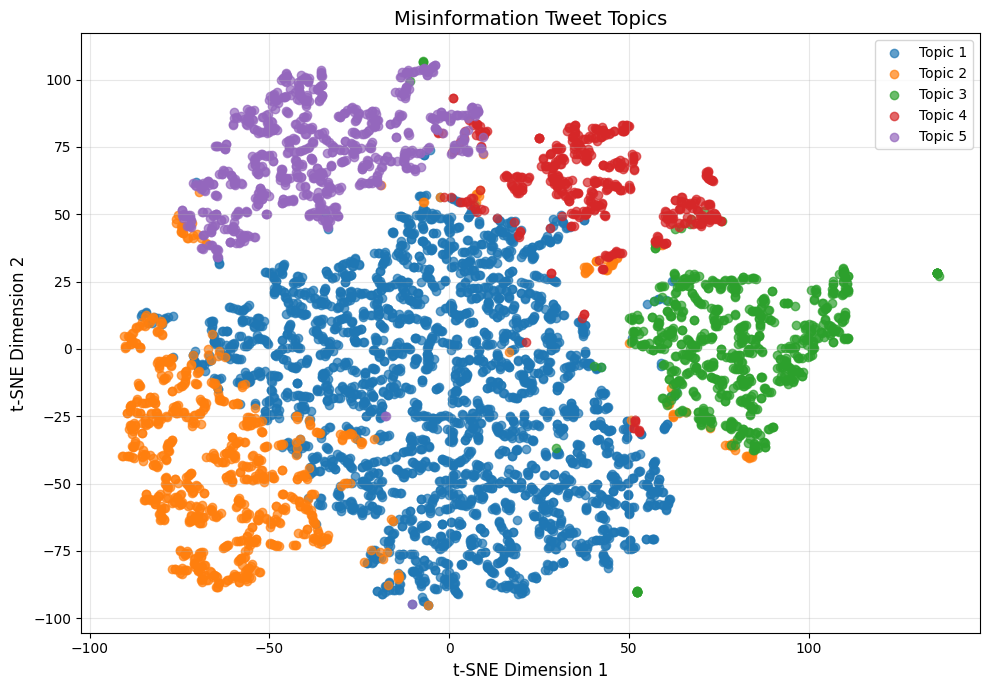

In [ ]:

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# NB I RENMAED THIS TOPICS, SHOULD BE CLUSTERS.
# Step 1: Clustering using KMeans
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(lsa_matrix)

# Add cluster labels to the original dataset
misinfo_cases['cluster'] = clusters

# Step 2: Dimensionality reduction for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, learning_rate=200)
tsne_matrix = tsne.fit_transform(lsa_matrix)

# Step 3: Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    cluster_points = tsne_matrix[clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1], label=f"Topic {cluster+1}", alpha=0.7
    )

plt.title("Misinformation Tweet Topics", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Extend vocabulary to include topics
with open("./cache/vocab_idx.pkl", "rb") as f:
    vocab_idx = pickle.load(f)
    
vocabulary = vocab_idx
extended_vocabulary = list(vocabulary) + list(topics_df.columns)

# Map embeddings for the extended vocabulary
def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        if word in pre_trained_embeddings:
            embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
        else:
            # Assign random embeddings for missing words (e.g., topics)
            embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)
    return embedding_matrix

# Generate embeddings for the extended vocabulary

ft_path = "./cc.en.300.bin"
ft = fasttext.load_model(ft_path)

mapped_pretrained_embeddings = embedding_mapping_fasttext(
    vocabulary=extended_vocabulary,
    pre_trained_embeddings=ft
)

# Reduce embeddings to 2D
embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)
embedding_matrix = embedding_tensor.numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Map reduced embeddings to all nodes (including topics)
pos = {word: reduced_embeddings[idx] for idx, word in enumerate(extended_vocabulary)}

# Plot the network
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, node_size=500, font_size=10, edge_color="gray", alpha=0.7
)
plt.title("Keyword Network with FastText Embedding-based Layout", fontsize=14)
plt.show()


ValueError: ./cc.en.300.bin cannot be opened for loading!

In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # or PCA/UMAP
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Load your model & tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased_finetuned = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_uncased_finetuned.to(device).eval()

print("Model and tokenizer loaded successfully from:", model_path)

def get_embedding(text, model, tokenizer, device):
    """
    Returns the CLS embedding (or optionally the mean pooling)
    from the last hidden layer of the model.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs, output_hidden_states=True)
        # The last hidden state is output.hidden_states[-1]
        last_hidden_state = output.hidden_states[-1]  # shape: (batch_size, seq_len, hidden_size)
        # Let's use the [CLS] token embedding by default
        cls_embedding = last_hidden_state[:, 0, :].squeeze(0)
    return cls_embedding.cpu().numpy()

topics = topics_df.columns.tolist()

node_embeddings = {}
all_nodes = []

# 3a. Collect topic embeddings
for topic in topics:
    # Use the topic name itself as text, or a short representative phrase if you have one
    embedding = get_embedding(topic, bert_uncased_finetuned, bert_tokenizer, device)
    node_embeddings[topic] = embedding
    all_nodes.append(topic)

# 3b. Collect keyword embeddings
for topic in topics:
    for keyword in topics_df[topic]:
        keyword_str = keyword.strip()
        if keyword_str not in node_embeddings:  # Avoid duplicate embeddings
            embedding = get_embedding(keyword_str, bert_uncased_finetuned, bert_tokenizer, device)
            node_embeddings[keyword_str] = embedding
            all_nodes.append(keyword_str)

X = np.array([node_embeddings[node] for node in all_nodes])

# 4. Apply t-SNE to get 2D vectors
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_2d = tsne.fit_transform(X)

# We'll store the 2D coords in a dictionary keyed by node
pos_dict = {}
for node, (x, y) in zip(all_nodes, X_2d):
    pos_dict[node] = (x, y)

G = nx.Graph()

# Example: for each topic i, we take each word in topics_df[topic_i]
# and link them with an edge whose weight is lsa_model.components_[i][j]
# (assuming j indexes the same keyword in that row)
for i, topic in enumerate(topics):
    # i-th row in lsa_model.components_ corresponds to weights for topic i
    # We'll match each keyword and weight by index
    for keyword_index, keyword in enumerate(topics_df[topic]):
        weight = lsa_model.components_[i][keyword_index]
        # Add an edge between the topic name and the keyword
        G.add_edge(topic, keyword, weight=weight)

plt.figure(figsize=(14, 10))

# 6a. Draw the graph using our pos_dict as node positions
nx.draw(
    G, 
    pos_dict,
    with_labels=True,
    node_size=500,
    font_size=10,
    edge_color="gray",
    alpha=0.7
)

plt.title("Topic–Keyword Network (positioned by Transformer Embeddings)", fontsize=14)
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Step 1: Prepare the embeddings
embedding_matrix = embeddings.cpu().detach().numpy().reshape(embeddings.shape[0], -1)

# Step 2: Dimensionality Reduction using t-SNE (or PCA as an alternative)
# t-SNE
#tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
#reduced_embeddings = tsne.fit_transform(embedding_matrix)

# PCA (if you want a faster alternative)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Step 3: Assign colors based on topics
# Assume `topics` is a list where each entry corresponds to the topic of a document
# Example: topics = ["topic1", "topic2", ...]
topic_labels = topics_df.columns  # Get topic labels from your DataFrame
topic_indices = np.argmax(lsa_model.transform(embedding_matrix), axis=1)  # Assign topics

# Generate a color map
unique_topics = np.unique(topic_labels)
color_map = {topic: plt.cm.tab10(i / len(unique_topics)) for i, topic in enumerate(unique_topics)}

# Step 4: Plot the embeddings
plt.figure(figsize=(10, 8))
for topic in unique_topics:
    indices = np.where(topic_indices == topic_labels.index(topic))[0]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=topic,
        alpha=0.7,
        edgecolors="k",
    )

plt.title("2D Visualization of Embeddings by Topic")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Topics", loc="best")
plt.show()
